In [23]:
import lmfit
from lmfit.models import GaussianModel,LorentzianModel
import numpy as np
from matplotlib import pyplot as plt
import rampy as rp
import scipy
import spectrochempy
class raman_analyzer():
    def __init__(self,name,min,max):
        self.name = name
        self.min = min
        self.max = max
        self.spectrum = np.genfromtxt(self.name)
        self.spectrum_resample =[]
        self.spectrum_corr = []
        self.spectrum_fit = []
        self.ese0 = 0.0
        self.sigma = 0.0
        self.y_base = []
        self.peak_wavenumber = []
        self.peak_signal = []
        self.raman()
        self.peak_finder()
    def raman(self):
        x_new = np.arange(self.min, self.max, 0.5)
        y_new = rp.resample(self.spectrum[:,0], self.spectrum[:,1], x_new)
        self.spectrum_resample = np.vstack((x_new,y_new)).T
        y_smo_10 = rp.smooth(self.spectrum_resample[:,0],self.spectrum_resample[:,1],method="whittaker",Lambda=3000,window_length=7)
        self.spectrum_resample = np.vstack((x_new,y_smo_10)).T
        d = scipy.signal.argrelextrema(self.spectrum_resample[:,1], np.less)
        points = len(d[0])
        bir=np.zeros((points,2))
        for i in range(len(d[0])):
            wavenumber=self.spectrum_resample[d[0][i]][0]
            bir[i][0]=wavenumber
            bir[i][1]=wavenumber+5
        y_corr, self.y_base = rp.baseline(self.spectrum_resample[:,0],self.spectrum_resample[:,1],bir,'drPLS')
        x = self.spectrum_resample[:,0]
        x_fit = x[np.where((x > self.min)&(x < self.max))]
        y_fit = y_corr[np.where((x > self.min)&(x < self.max))]
        self.spectrum_corr = np.column_stack((x_fit,y_fit))
        self.ese0 = np.sqrt(abs(y_fit[:,0]))/abs(y_fit[:,0]) # the relative errors after baseline subtraction
        y_fit[:,0] = y_fit[:,0]/np.amax(y_fit[:,0])*10 # normalise spectra to maximum intensity, easier to handle
        self.spectrum_fit = np.column_stack((x_fit,y_fit))
        self.sigma = abs(self.ese0*y_fit[:,0])
    def peak_finder(self):
        peaks_1 = scipy.signal.find_peaks(self.spectrum_fit.T[1])
        saddles = scipy.signal.argrelmin(self.spectrum_fit.T[1])
        peaks = np.insert(peaks_1[0],0,saddles[0])
        peaks = np.sort(peaks)
        for peak in peaks:
            self.peak_wavenumber.append(self.spectrum_fit.T[0][peak])
            self.peak_signal.append(self.spectrum_fit.T[1][peak])
def raman_plot(a,min,max):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(a.spectrum_resample[:,0],a.spectrum_resample[:,1],'ko',markersize=1,label='spectrum_resample')
    plt.plot(a.spectrum_corr[:,0],a.spectrum_corr[:,1],'ro',markersize=1,label='spectrum_corr')
    plt.plot(a.spectrum_resample[:,0],a.y_base,'g--',label='baseline',linewidth=2)
    plt.xlim(min,max)
    plt.xlabel("Raman shift, cm$^{-1}$", fontsize = 12)
    plt.ylabel("Normalized intensity, a. u.", fontsize = 12)
    plt.legend(fontsize=10)
    plt.subplot(1,2,2)
    plt.plot(a.spectrum_fit[:,0],a.spectrum_fit[:,1],'#F5420a',marker='.',markersize=3,label='spectrum_fit')
    plt.scatter(a.peak_wavenumber,a.peak_signal,s=80,c='#0af57c',marker='o')
    plt.xlim(min,max)
    plt.xlabel("Raman shift, cm$^{-1}$", fontsize = 12)
    name = a.name
    plt.savefig(name+'.png')

In [40]:
a = raman_analyzer('1.dat',200,3000)

(-1.0, 11.0)

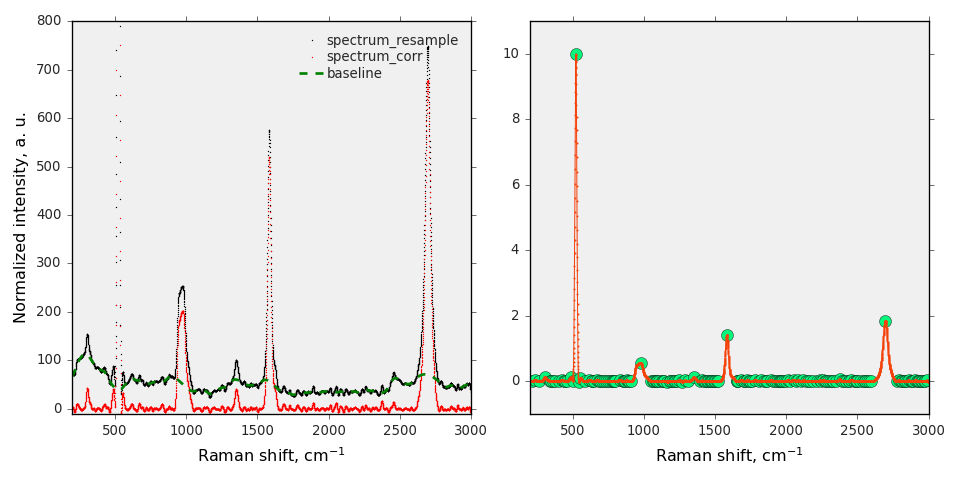

In [43]:
raman_plot(a,200,3000)
plt.subplot(1,2,1)
plt.ylim(-10,800)
plt.subplot(1,2,2)
plt.ylim(-1,11)